### Get side view data

In [1]:
os.chdir("/home/plumail/stage/minisource")

In [84]:
import os
import csv
import numpy as np
from modules.utils import load_array

data_path = "/data/plumail/real_data/inputs/Nicollo_STED"
views_path = os.path.join(data_path, "views.csv")
particules_cropped_dir = os.path.join(data_path, "annotated/cropped/positive")

image_name = None
i = 0
list_side_particles = []
with open(views_path, "r") as f:
    reader = csv.reader(f)
    for particle in reader:
        if particle[0] != image_name:
            image_name = particle[0]
            image_name_noext, _ = os.path.splitext(image_name)
            i = 0
        else:
            i += 1
        if particle[1] == '1':
            list_side_particles.append(os.path.join(particules_cropped_dir, image_name_noext+'_'+str(i)+'.npz'))

patches = np.stack([load_array(p) for p in list_side_particles], axis=0) # (N,z,y,x)

# project and normalize
#patches = patches.sum(axis=1)
patches = patches[:,6]
flatten_patches = patches.reshape(patches.shape[0], -1)
min_patch, max_patch = flatten_patches.min(axis=1), flatten_patches.max(axis=1)
min_patch = min_patch[:,None,None]
max_patch = max_patch[:,None,None]
patches = (patches - min_patch) / (max_patch - min_patch)
patches.shape

(15, 24, 24)

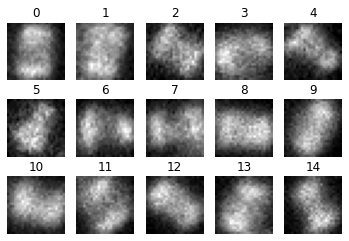

In [85]:
import matplotlib.pyplot as plt

for i in range(patches.shape[0]):
    p = patches[i]
    plt.subplot(3,5,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(p, cmap='gray')


In [88]:
params, avrg_particle, variance_map = iterative_alignment(patches)

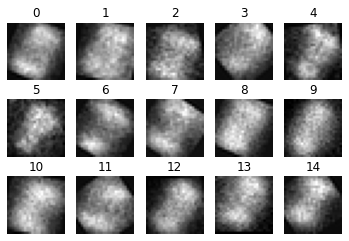

In [89]:
import matplotlib.pyplot as plt

for i in range(patches.shape[0]):
    p = patches[i]
    plt.subplot(3,5,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(transform_patch(p, *params[i], pad=True), cmap='gray')

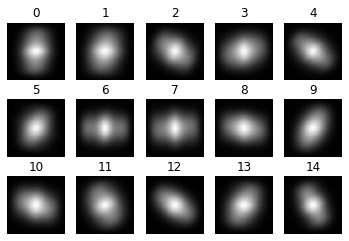

In [90]:
from scipy.signal import correlate

acf = [correlate(p,p) for p in patches]
for i in range(patches.shape[0]):
    p = patches[i]
    plt.subplot(3,5,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(acf[i], cmap='gray')

In [91]:
from scipy import ndimage as ndii

def polar(image, angles=None, radii=None):
    """Return polar transformed image and log base."""
    shape = image.shape
    center = shape[0] / 2, shape[1] / 2
    if angles is None:
        angles = shape[0]
    if radii is None:
        radii = shape[1]
    theta = np.empty((angles, radii), dtype='float64')
    theta.T[:] = np.linspace(0, 2*np.pi, angles, endpoint=False)
    # d = radii
    d = np.hypot(shape[0] - center[0], shape[1] - center[1])
    #log_base = 10.0 ** (np.log10(d) / (radii))
    radius = np.empty_like(theta)
    #radius[:] = (
    #    np.power(log_base, np.arange(radii, dtype='float64')) - 1.0
    #)
    radius[:] = np.linspace(0, d, radii)
    x = radius * np.sin(theta) + center[0]
    y = radius * np.cos(theta) + center[1]
    output = np.empty_like(x)
    ndii.map_coordinates(image, [x, y], output=output)
    return output

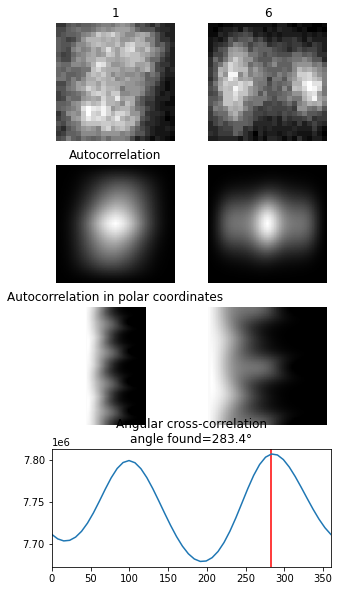

In [92]:
i, j = 1, 6
polar0 = polar(acf[i])
polar1 = polar(acf[j])
h = polar0.shape[0]
repeated_polar0 = np.concatenate([polar0, polar0], axis=0)

plt.figure(figsize=(5,10))
plt.subplot(4,2,1)
plt.axis('off')
plt.title(str(i))
plt.imshow(patches[i], cmap='gray')
plt.subplot(4,2,2)
plt.axis('off')
plt.title(str(j))
plt.imshow(patches[j], cmap='gray')
plt.subplot(4,2,3)
plt.axis('off')
plt.title("Autocorrelation")
plt.imshow(acf[i], cmap='gray')
plt.subplot(4,2,4)
plt.axis('off')
plt.imshow(acf[j], cmap='gray')
plt.subplot(4,2,5)
plt.axis('off')
plt.title("Autocorrelation in polar coordinates")
plt.imshow(repeated_polar0, cmap='gray')
plt.subplot(4,2,6)
plt.axis('off')
plt.imshow(polar1, cmap='gray')

corr = correlate(repeated_polar0, polar1, mode='valid')
plt.subplot(4,1,4)
plt.xlim(0,360)
x = np.linspace(0,360,corr.shape[0])
best_angle = x[corr.argmax()]
plt.title(f"Angular cross-correlation\nangle found={best_angle:.1f}°")
plt.axvline(best_angle, 0, 1, c="red")
plt.plot(x, corr[:,0])

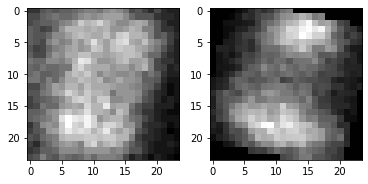

In [93]:
rotated_patch = ndii.rotate(patches[j], -best_angle, reshape=False)
plt.subplot(121)
plt.imshow(patches[i], cmap='gray')
plt.subplot(122)
plt.imshow(rotated_patch, cmap='gray')

121.23467056782002
[0.5 1.5]
22 23


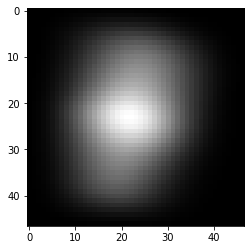

In [94]:
ccf = correlate(patches[i], rotated_patch, mode='full')
plt.imshow(ccf, cmap='gray')
y, x = np.unravel_index(ccf.argmax(), ccf.shape)
print(ccf[y,x])
center = ccf.shape[0] / 2, ccf.shape[1] / 2
r = np.array([center[0]-y, center[1]-x])
print(r)
print(x, y)

119.96166093708183


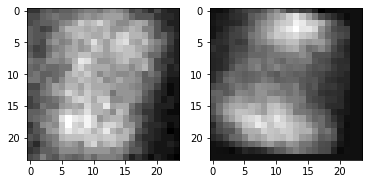

In [95]:
shifted_rotated_patch = ndii.shift(rotated_patch, -r)
print((shifted_rotated_patch * patches[i]).sum())
plt.subplot(121)
plt.imshow(patches[i], cmap='gray')
plt.subplot(122)
plt.imshow(shifted_rotated_patch, cmap='gray')

In [96]:
def get_rotation_angle(im1, im2):
    acf1, acf2 = correlate(im1, im1), correlate(im2, im2)
    polar1 = polar(acf1)
    polar2 = polar(acf2)
    repeated_polar1 = np.concatenate([polar1, polar1], axis=0)
    angular_correlation = correlate(repeated_polar1, polar2, mode='valid')
    x = np.linspace(0, 360, angular_correlation.shape[0])
    best_angle = x[angular_correlation.argmax()]
    return best_angle

def get_translation(im1, im2):
    ccf = correlate(im1, im2, mode='full')
    y, x = np.unravel_index(ccf.argmax(), ccf.shape)
    center = (ccf.shape[0]-1) / 2, (ccf.shape[1]-1) / 2
    return ccf[y, x], center[0] - y, center[1] - x

def get_transform(im1, im2):
    angle = get_rotation_angle(im1, im2)
    rotated_patch1 = ndii.rotate(im2, -angle, reshape=False)
    rotated_patch2 = ndii.rotate(im2, -(angle+180), reshape=False)
    ccf1, ty1, tx1 = get_translation(im1, rotated_patch1)
    ccf2, ty2, tx2 = get_translation(im1, rotated_patch2)
    if ccf1 > ccf2:
        return angle, ty1, tx1
    else:
        return angle+180, ty2, tx2

polar_dict = {}
def get_polar_special(im):
    global polar_dict
    k = im.tobytes()
    if k in polar_dict:
        return polar_dict[k]
    else:
        p = polar(correlate(im, im))
        polar_dict[k] = p
        return p

def get_rotation_angle_special(im1, im2):
    polar1, polar2 = get_polar_special(im1), get_polar_special(im2)
    repeated_polar1 = np.concatenate([polar1, polar1], axis=0)
    angular_correlation = correlate(repeated_polar1, polar2, mode='valid')
    x = np.linspace(0, 360, angular_correlation.shape[0])
    best_angle = x[angular_correlation.argmax()]
    return best_angle

def get_transform_special(im1, im2):
    angle = get_rotation_angle_special(im1, im2)
    rotated_patch1 = ndii.rotate(im2, -angle, reshape=False)
    rotated_patch2 = ndii.rotate(im2, -(angle+180), reshape=False)
    ccf1, ty1, tx1 = get_translation(im1, rotated_patch1)
    ccf2, ty2, tx2 = get_translation(im1, rotated_patch2)
    if ccf1 > ccf2:
        return angle, ty1, tx1
    else:
        return angle+180, ty2, tx2

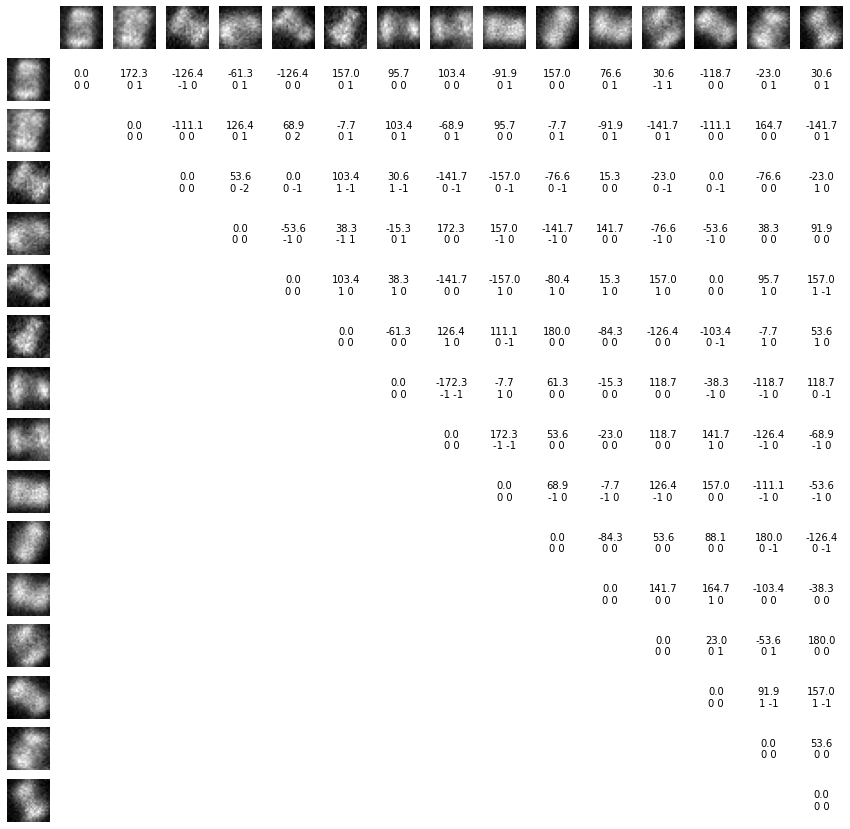

In [97]:
plt.figure(figsize=(15,15))

matrix_shape = patches.shape[0]+1, patches.shape[0]+1
for i in range(patches.shape[0]):
    plt.subplot(*matrix_shape, i+2)
    plt.axis('off')
    plt.imshow(patches[i], cmap='gray')
    plt.subplot(*matrix_shape, (i+1)*matrix_shape[1]+1)
    plt.axis('off')
    plt.imshow(patches[i], cmap='gray')

transforms = np.zeros((patches.shape[0], patches.shape[0], 3))
for i in range(patches.shape[0]):
    for j in range(patches.shape[0]):
        if j >= i:
            angle, ty, tx = get_transform(patches[i], patches[j])
            transforms[i, j] = angle, ty, tx
            while angle > 180 and angle > 0: angle = angle - 360
            plt.subplot(*matrix_shape, matrix_shape[1]+2+i*matrix_shape[1]+j)
            plt.axis('off')
            plt.text(0.5, 0.5, f"{angle:.1f}\n{ty:.0f} {tx:.0f}", horizontalalignment='center', verticalalignment='center')

### Iterative alignment

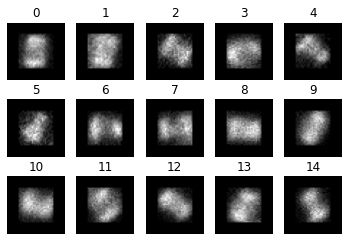

In [98]:
patches_padded = np.pad(patches, [(0,0), (8,8), (8,8)])
for i in range(patches.shape[0]):
    p = patches_padded[i]
    plt.subplot(3,5,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(p, cmap='gray')

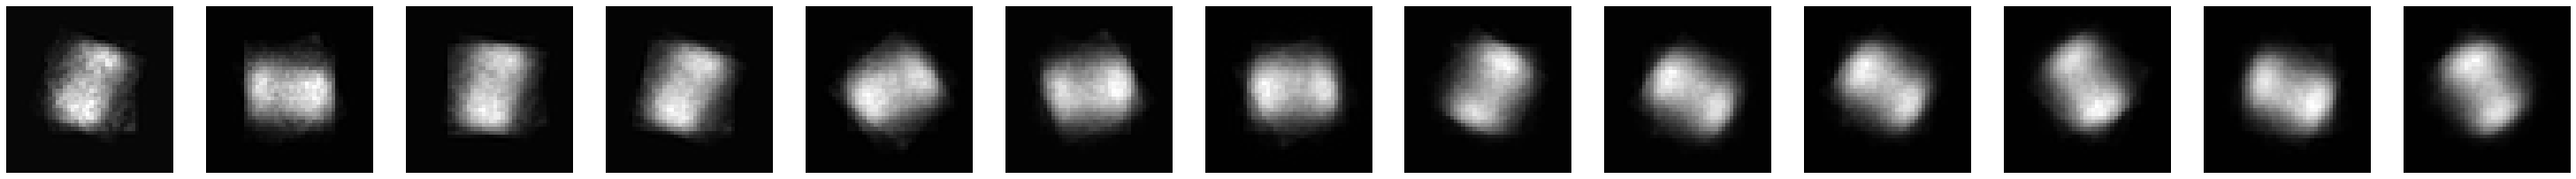

In [99]:
def transform_patch(patch, R, ty, tx, pad=False):
    if pad:
        h, w = patch.shape
        padw = int(h*(2**0.5 -1) + 2)
        patch = np.pad(patch, [(padw,padw),(padw,padw)])
    r_patch = ndii.rotate(patch, -R, reshape=False)
    s_patch = ndii.shift(r_patch, np.array([-ty, -tx]))
    if pad:
        s_patch = s_patch[padw:-padw, padw:-padw]
    return s_patch

pad = 10
patches_padded = np.pad(patches, [(0,0), (pad,pad), (pad,pad)])
patches_list = patches_padded
h, w = patches_list.shape[1], patches_list.shape[2]

# Initialize tree
N = patches.shape[0]
order = np.random.choice(np.arange(N), N, replace=False)

# Center patches
for i in range(N):
    y_centermass, x_centermass = ndii.center_of_mass(patches_list[order[i]])
    center = (h-1) / 2, (w-1) / 2
    ty, tx = center[0] - y_centermass, center[1] - x_centermass
    patches_list[order[i]] = transform_patch(patches_list[order[i]], 0, -ty, -tx)
    y_centermass, x_centermass = ndii.center_of_mass(patches_list[order[i]])

tree = [2, order[0], order[1], get_transform(patches_list[order[0]], patches_list[order[1]])]

def build_particle(patches, tree, R, ty, tx):
    r_, ty_, tx_ = tree[3]
    if type(tree[2]) is list:
        m = tree[0]
        p = patches[tree[1]]
        return (transform_patch(p, R, ty, tx) + (m-1)*build_particle(patches, tree[2], R+r_, ty+ty_, tx_+tx)) / m
    else:
        assert tree[0] == 2
        r_, ty_, tx_ = tree[3]
        p = (patches[tree[1]] + transform_patch(patches[tree[2]], r_, ty_, tx_)) / 2
        return transform_patch(p, R, ty, tx)


plt.figure(figsize=(14*4,4))
while tree[0] < N:
    m = tree[0]
    p_right = build_particle(patches_list, tree, 0, 0, 0)
    # center the particle
    y_centermass, x_centermass = ndii.center_of_mass(p_right)
    ty_corr, tx_corr = center[0] - y_centermass, center[1] - x_centermass

    # find the transformation
    p_left = patches_list[order[m]]
    angle, ty, tx = get_transform(p_left, p_right)
    tree = [m+1, order[m], tree, (angle, ty-ty_corr, tx-tx_corr)]

    plt.subplot(1,14,m-1)
    plt.axis('off')
    plt.imshow(p_right, cmap='gray')

# center the final particle
plt.subplot(1,14,m-1)
plt.axis('off')
plt.imshow(build_particle(patches_list, tree,0,0,0), cmap='gray')

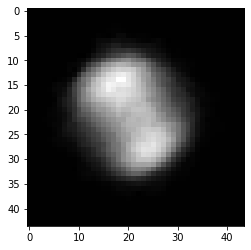

In [100]:
plt.imshow(build_particle(patches_list, tree, 0, 0, 0), cmap='gray')

##### Find back all the particles rotations and translations

In [113]:
avrg_particle = build_particle(patches_list, tree, 0, 0, 0)
patches_param = [(0,0,0) for i in range(N)]

def fill_params(params, tree, R, ty, tx):
    r_, ty_, tx_ = tree[3]
    if type(tree[2]) is list:
        fill_params(params, tree[2], R+r_, ty+ty_, tx+tx_)
        params[tree[1]] = (R%360, ty, tx)
    else:
        params[tree[1]] = (R%360, ty, tx)
        params[tree[2]] = ((R+r_)%360, ty+ty_, tx+tx_)

fill_params(patches_param, tree, 0, 0, 0)

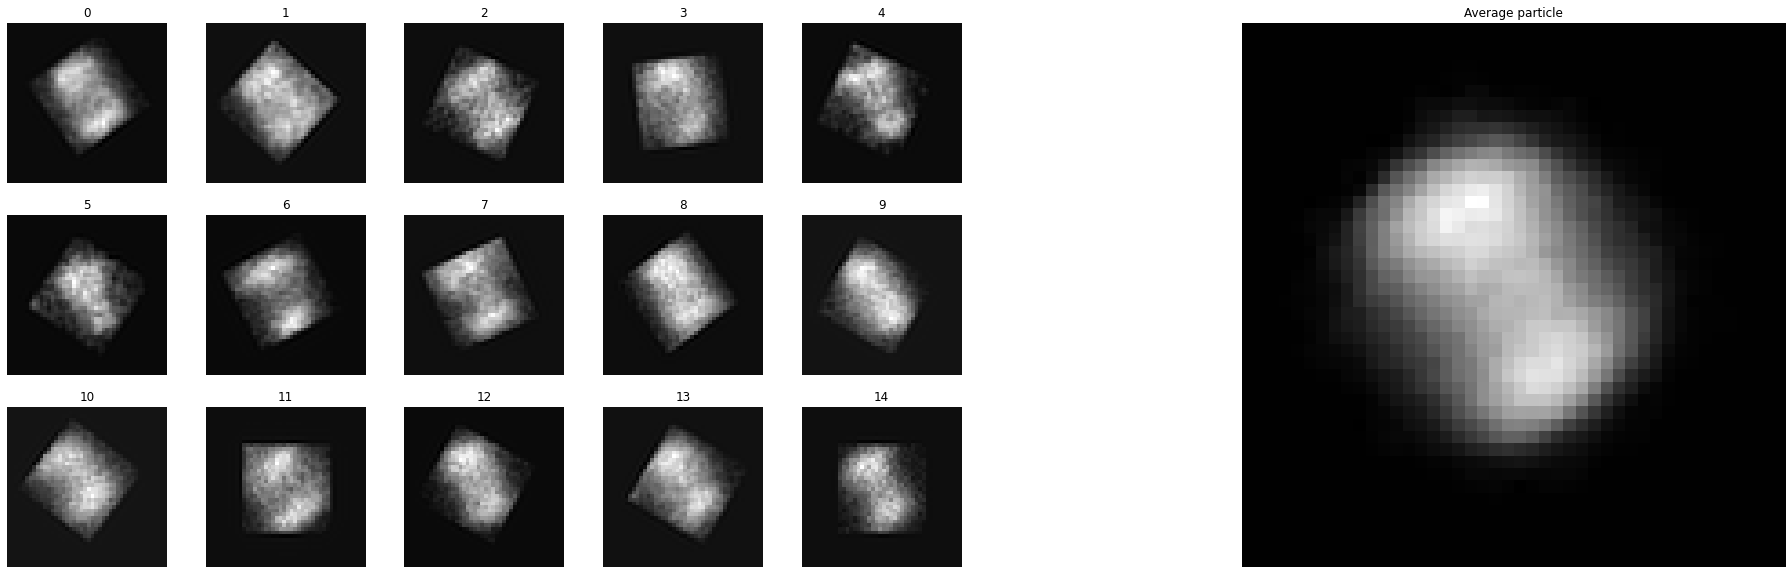

In [114]:
plt.figure(figsize=(35,10))

for i in range(patches.shape[0]):
    p = patches_padded[i]
    plt.subplot(3,10,1+10*(i//5)+i%5)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(transform_patch(patches_list[i], *patches_param[i]), cmap='gray')

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Average particle')
plt.imshow(avrg_particle, cmap='gray')

#### Second phase of the algorithm

In [103]:
order = np.arange(N)

distance = np.array([3,3,3])
epsilon = 1e-3
while distance.sum() > epsilon:
    np.random.shuffle(order)
    new_patches_param = np.array([(0,0,0) for i in range(N)])
    for i in range(N):
        p = patches_list[order[i]]
        avrg_particle = (N*avrg_particle - transform_patch(p, *patches_param[order[i]])) / (N-1)
        R, ty, tx = get_transform(p, avrg_particle)

        new_patches_param[order[i]] = np.array([-R, -ty, -tx])
        avrg_particle = (transform_patch(p, *new_patches_param[order[i]]) + (N-1) * avrg_particle) / N
    distances = np.square((new_patches_param - patches_param) / np.array([360,1,1]))
    distance = distances.mean(axis=0) ** 0.5
    patches_param = new_patches_param

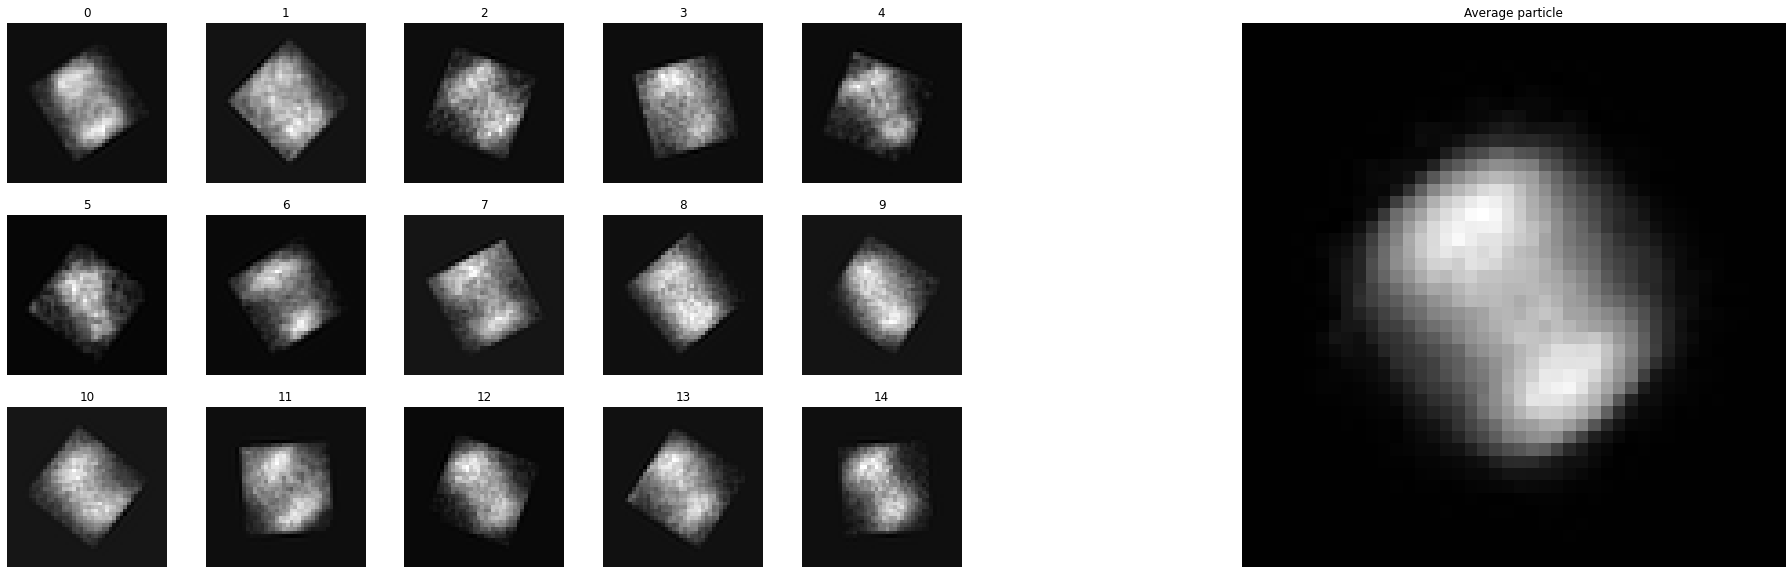

In [104]:
plt.figure(figsize=(35,10))

for i in range(patches.shape[0]):
    p = patches_padded[i]
    plt.subplot(3,10,1+10*(i//5)+i%5)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(transform_patch(patches_padded[i], *patches_param[i]), cmap='gray')

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Average particle')
plt.imshow(avrg_particle, cmap='gray')

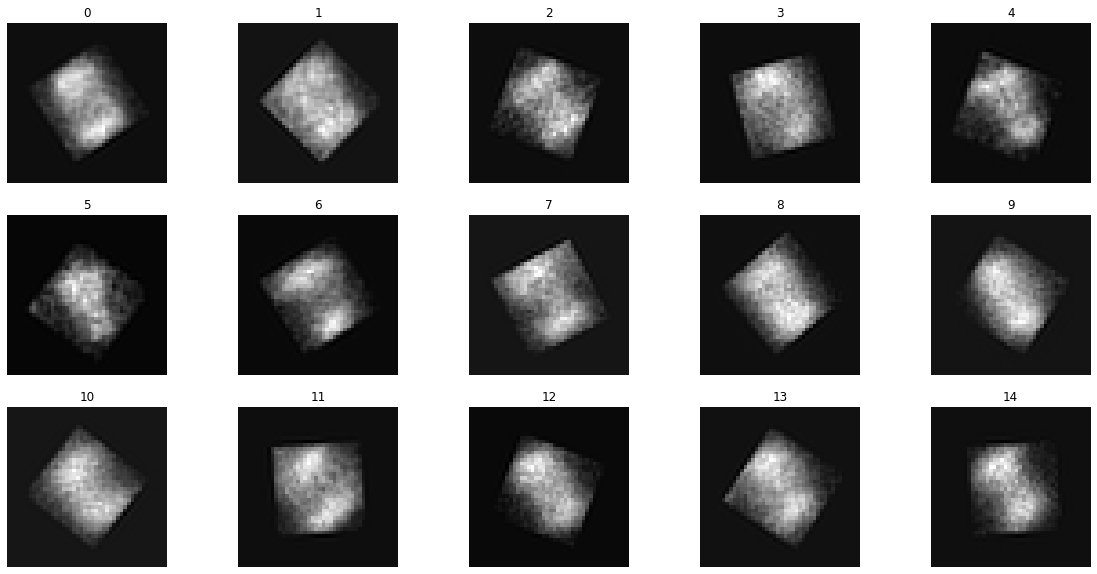

In [105]:
plt.figure(figsize=(20,10))

for i in range(patches.shape[0]):
    p = patches_padded[i]
    plt.subplot(3,5,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(transform_patch(patches_padded[i], *patches_param[i]), cmap='gray')

#### Wrapping

In [106]:
from time import time
def iterative_alignment(particles, epsilon=1e-2, max_iter=20):
    N, h, w = particles.shape

    pad = int(h*(2**0.5 -1) + 2)
    patches_padded = np.pad(particles, [(0,0), (pad,pad), (pad,pad)])
    _, H, W = patches_padded.shape

    # Phase A : build an average particle
    # Initialize tree
    patches_param = np.zeros((N,3))
    order = np.random.choice(np.arange(N), N, replace=False)
    t0 = time()
    # Center patches
    patches_padded_centered = np.zeros_like(patches_padded)
    for i in range(N):
        y_centermass, x_centermass = ndii.center_of_mass(patches_padded[order[i]])
        center = (H-1) / 2, (W-1) / 2
        ty, tx = center[0] - y_centermass, center[1] - x_centermass
        patches_param[i] = [0, -ty, -tx]
        patches_padded_centered[order[i]] = transform_patch(patches_padded[order[i]], 0, -ty, -tx)
    t1 = time()
    tree = [2, order[0], order[1], get_transform(patches_padded_centered[order[0]], patches_padded_centered[order[1]])]

    while tree[0] < N:
        m = tree[0]
        p_right = build_particle(patches_padded_centered, tree, 0, 0, 0)
        # center the particle
        y_centermass, x_centermass = ndii.center_of_mass(p_right)
        ty_corr, tx_corr = center[0] - y_centermass, center[1] - x_centermass

        # find the transformation
        p_left = patches_padded_centered[order[m]]
        angle, ty, tx = get_transform(p_left, p_right)
        tree = [m+1, order[m], tree, (angle, ty-ty_corr, tx-tx_corr)]
    t2 = time()
    # Phase B : stabilize the average particle
    avrg_particle = build_particle(patches_padded_centered, tree, 0, 0, 0)
    patches_param_centered = np.zeros_like(patches_param)
    fill_params(patches_param_centered, tree, 0, 0, 0)

    patches_param = patches_param + patches_param_centered

    order = np.arange(N)

    distance = np.array([3,3,3])
    j = 0
    t3 = time()
    dt_gettransform = []
    dt_transform = []
    while distance.sum() > epsilon and j < max_iter:
        j += 1
        np.random.shuffle(order)
        new_patches_param = np.array([(0,0,0) for i in range(N)])
        last_transforms = [None for i in range(N)]
        for i in range(N):
            p = patches_padded[order[i]]
            transformed_p = transform_patch(p, *patches_param[order[i]]) if last_transforms[order[i]] is None else last_transforms[order[i]]
            avrg_particle = (N*avrg_particle - transformed_p) / (N-1)
            t6 = time()
            R, ty, tx = get_transform_special(p, avrg_particle)
            t7 = time()

            new_patches_param[order[i]] = np.array([-R, -ty, -tx])
            new_transformed_p = transform_patch(p, *new_patches_param[order[i]])
            t8 = time()
            last_transforms[order[i]] = new_transformed_p
            avrg_particle = (new_transformed_p + (N-1) * avrg_particle) / N
            dt_gettransform.append(t7-t6)
            dt_transform.append(t8-t7)

        distances = np.square((new_patches_param - patches_param) / np.array([360,1,1]))
        distance = distances.mean(axis=0) ** 0.5
        patches_param = new_patches_param
    t4 = time()
    unpadded_avrg_particle = avrg_particle[pad:-pad, pad:-pad]
    patches_param[:, 0] = patches_param[:, 0] % 360

    variance_map = sum([(transform_patch(particles[i], *patches_param[i]) - unpadded_avrg_particle)**2 for i in range(N)]) / (N-1)
    t5 = time()

    dt_gettransform = np.array(dt_gettransform)
    dt_transform = np.array(dt_transform)
    #print("Times:")
    #print("Phase A")
    #print(f"Center patches : {t1-t0:.2f}")
    #print(f"Build average particle : {t2-t1:.2f}")
    #print(f"Phase B : {t4-t3:.2f}")
    #print(f"get_transform mean : {dt_gettransform.mean():.4f}, total : {dt_gettransform.sum():.3f}")
    #print(f"transform mean : {dt_transform.mean():.4f}, total : {dt_transform.sum():.3f}")
    #print(f"Build variance map : {t5-t4:.2f}")

    
    return patches_param, unpadded_avrg_particle, variance_map

In [107]:
data_path = "/data/plumail/real_data/inputs/Nicollo_STED"
views_path = os.path.join(data_path, "views.csv")
particules_cropped_dir = os.path.join(data_path, "annotated/cropped/positive")

image_name = None
i = 0
list_side_particles = []
with open(views_path, "r") as f:
    reader = csv.reader(f)
    for particle in reader:
        if particle[0] != image_name:
            image_name = particle[0]
            image_name_noext, _ = os.path.splitext(image_name)
            i = 0
        else:
            i += 1
        if particle[1] == '1':
            list_side_particles.append(os.path.join(particules_cropped_dir, image_name_noext+'_'+str(i)+'.npz'))

patches = np.stack([load_array(p) for p in list_side_particles], axis=0) # (N,z,y,x)

# project and normalize
#patches = patches.sum(axis=1)
patches = patches[:,6]
flatten_patches = patches.reshape(patches.shape[0], -1)
min_patch, max_patch = flatten_patches.min(axis=1), flatten_patches.max(axis=1)
min_patch = min_patch[:,None,None]
max_patch = max_patch[:,None,None]
patches = (patches - min_patch) / (max_patch - min_patch)
patches.shape

(15, 24, 24)

0.11817736624810883


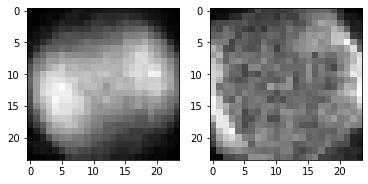

In [108]:
params, avrg_particle, variance_map = iterative_alignment(patches)
plt.subplot(1,2,1)
plt.imshow(avrg_particle, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(variance_map**0.5, cmap='gray')
print((variance_map**0.5).mean())

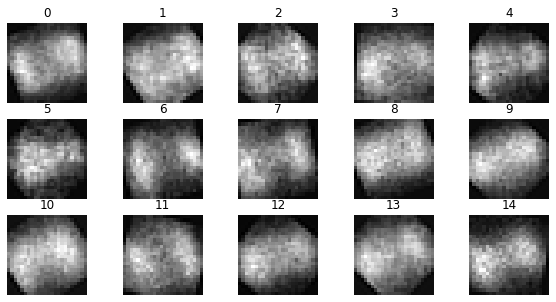

In [112]:
plt.figure(figsize=(10,5))

for i in range(patches.shape[0]):
    p = patches[i]
    plt.subplot(3,5,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(transform_patch(patches[i], *params[i], pad=True), cmap='gray')

(array([3., 1., 3., 0., 3., 2., 2., 0., 0., 1.]),
 array([0.0823199 , 0.0924457 , 0.10257149, 0.11269729, 0.12282308,
        0.13294888, 0.14307468, 0.15320047, 0.16332627, 0.17345206,
        0.18357786]),
 <BarContainer object of 10 artists>)

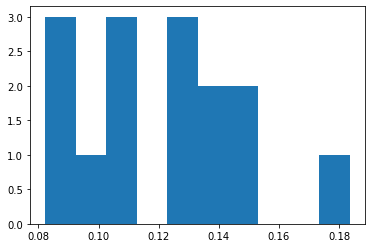

In [24]:
plt.hist([((transform_patch(patches[i], *params[i]) - avrg_particle)**2).mean()**0.5 for i in range(15)])

#### Test sur des données pickées

In [1]:
import pickle
from modules.utils import load_annotations

def get_patches(views_path, cropped_dir, orientations=1):
    if orientations is None: orientations = []
    if type(orientations) == int: orientations = [orientations]
    list_side_particles = []
    _, ext = os.path.splitext(views_path)
    if ext == '.pickle':
        with open(views_path, "rb") as f:
            pred_views = pickle.load(f)
            for img_name in pred_views:
                views, _, particle_names = pred_views[img_name]
                for v, p_name in zip(views, particle_names):
                    path = os.path.join(cropped_dir, p_name)
                    if v in orientations and os.path.exists(path):
                        list_side_particles.append(path)
    elif ext == '.csv':
        views = load_annotations(views_path)
        image_names = set(views[:,0])
        for image_name in image_names:
            views_im = views[views[:,0]==image_name]
            list_side_particles += [os.path.splitext(vi[0])[0]+'_'+str(i)+'.npz' for i, vi in enumerate(views_im) if vi[1]==1]
        list_side_particles = list(map(lambda x: os.path.join(cropped_dir, x), list_side_particles))

    patches = np.stack([load_array(p) for p in list_side_particles], axis=0) # (N,z,y,x)

    # project and normalize
    patches = patches.sum(axis=1)
    flatten_patches = patches.reshape(patches.shape[0], -1)
    min_patch, max_patch = flatten_patches.min(axis=1), flatten_patches.max(axis=1)
    min_patch = min_patch[:,None,None]
    max_patch = max_patch[:,None,None]
    patches = (patches - min_patch) / (max_patch - min_patch)
    return patches

ModuleNotFoundError: No module named 'modules'

Nicollo_STED

In [70]:
patches = get_patches(
    "/data/plumail/real_data/outputs/Nicollo_STED/tilt/pos40/pred_picked_particles/predictions.pickle",
    "/data/plumail/real_data/outputs/Nicollo_STED/picking/pos40/cropped/positive"
)

8 13


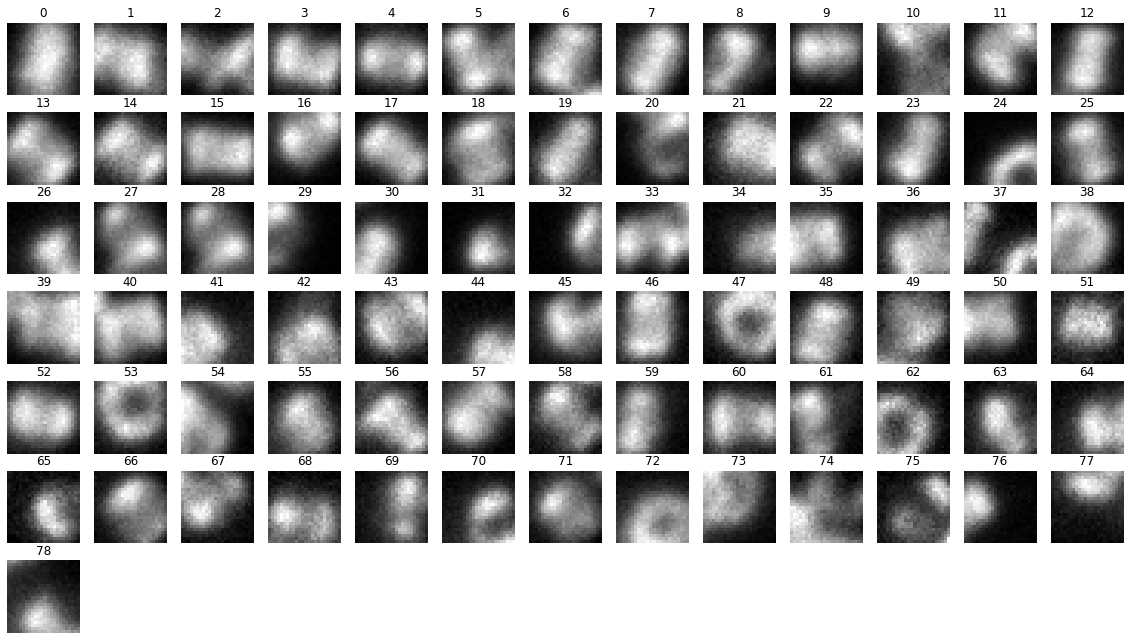

In [75]:
N = patches.shape[0]

plt.figure(figsize=(20,10))
h = int((N/1.5)**0.5) + 1
w = int(h * 1.5) + 1
print(h, w)

for i in range(patches.shape[0]):
    p = patches[i]
    plt.subplot(h,w,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(patches[i], cmap='gray')

plt.subplots_adjust(top=1.1)

In [76]:
params, avrg_particle, variance_map = iterative_alignment(patches)

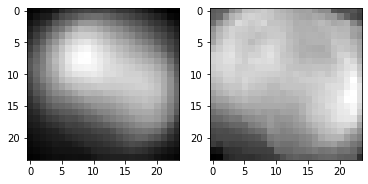

In [29]:
plt.subplot(1,2,1)
plt.imshow(avrg_particle, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(variance_map**0.5, cmap='gray')

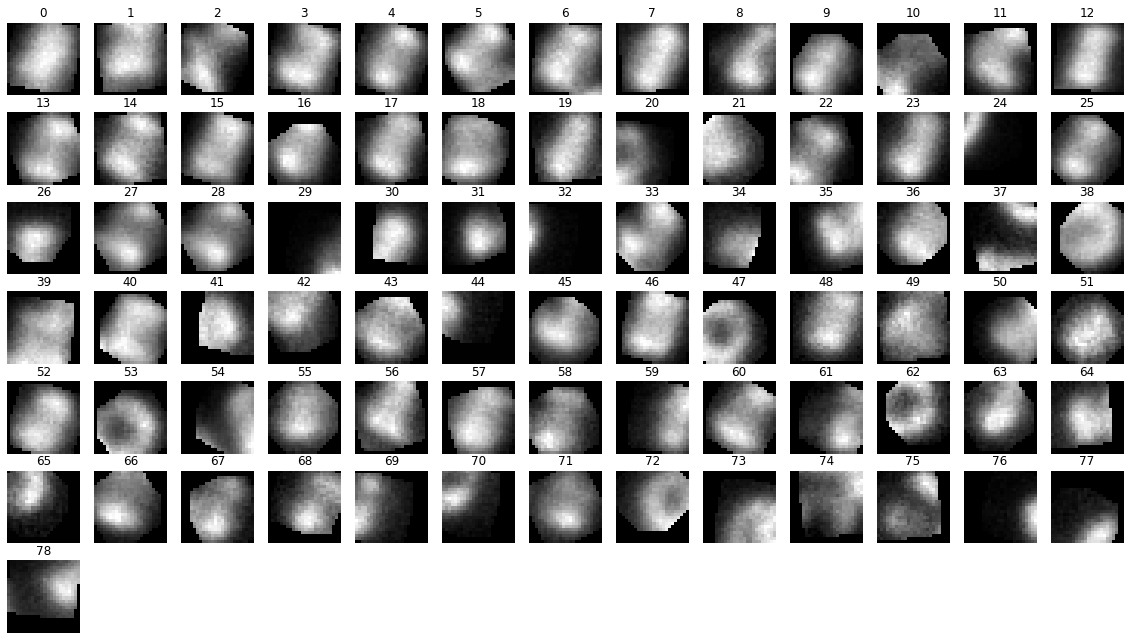

In [77]:
plt.figure(figsize=(20,10))

for i in range(patches.shape[0]):
    p = patches[i]
    plt.subplot(h,w,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(transform_patch(patches[i], *params[i]), cmap='gray')

plt.subplots_adjust(top=1.1)

#### Outliers removal

0.22946751835786008


(array([ 9.,  9.,  8., 15., 14.,  7.,  6.,  3.,  3.,  5.]),
 array([0.0932768 , 0.12451394, 0.15575109, 0.18698824, 0.21822538,
        0.24946253, 0.28069967, 0.31193682, 0.34317397, 0.37441111,
        0.40564826]),
 <BarContainer object of 10 artists>)

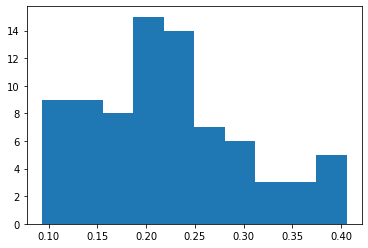

In [31]:
print((variance_map**0.5).mean())
std_mean = [((transform_patch(patches[i], *params[i]) - avrg_particle)**2).mean()**0.5 for i in range(N)]
plt.hist(std_mean)

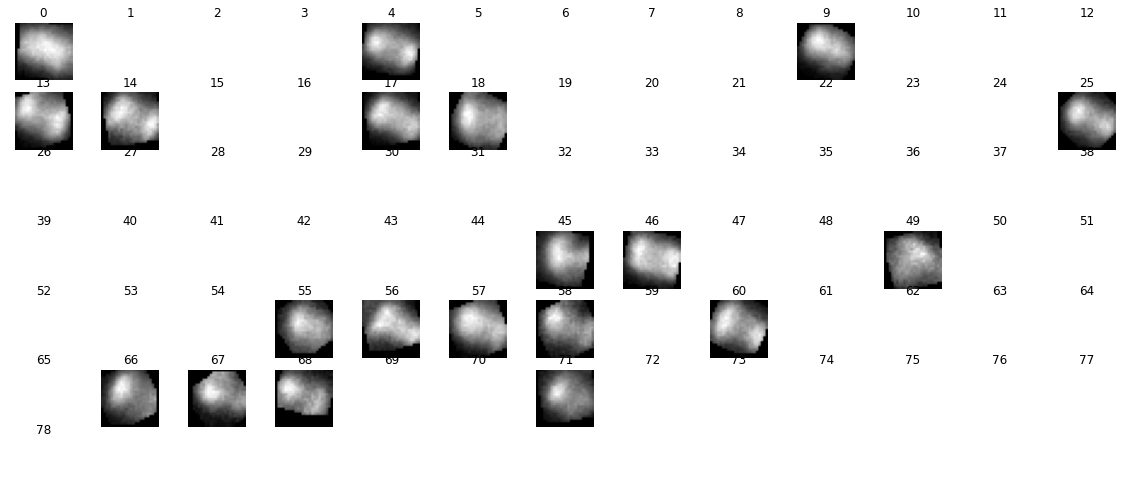

In [32]:
best_particles_index = np.argsort(std_mean)[:20]

plt.figure(figsize=(20,10))

for i in range(patches.shape[0]):
    p = patches[i]
    plt.subplot(h,w,i+1)
    plt.axis('off')
    plt.title(str(i))
    if i in best_particles_index:
        plt.imshow(transform_patch(patches[i], *params[i]), cmap='gray')

Suppression progressive des particules

In [33]:
def iterative_suppression(patches, n):
    N = patches.shape[0]
    assert n <= N
    I = int(np.ceil(np.log2(N/n)))
    print("iterations=",I)
    mask_keep = np.ones((N), dtype=bool)
    good_patches = patches.copy()
    for i in range(I):
        print("N=", good_patches.shape[0])
        params, avrg_particle, variance_map = iterative_alignment(good_patches)
        std = np.array([((transform_patch(good_patches[i], *params[i]) - avrg_particle)**2).mean()**0.5 for i in range(good_patches.shape[0])])
        if i < I-1: # not last iteration
            mask_keep[mask_keep] = std <= np.median(std)
        else:
            x = np.where(mask_keep)[0]
            mask_keep[x[np.argsort(std)[n:]]] = False
        
        good_patches = patches[mask_keep]
    
    params, avrg_particle, variance_map = iterative_alignment(good_patches)
    
    return mask_keep, params, avrg_particle, variance_map

Données Nicollo STED, on a détecté 79 particules "side", on cherche à en retrouver 20 de propres et à les recaler 

In [78]:
mask, params, avrg_particle, variance_map = iterative_suppression(patches, n=20)

iterations= 2
N= 79
N= 40


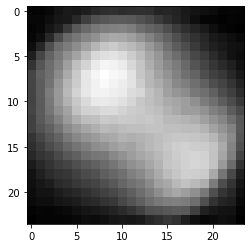

In [35]:
plt.imshow(avrg_particle, cmap='gray')

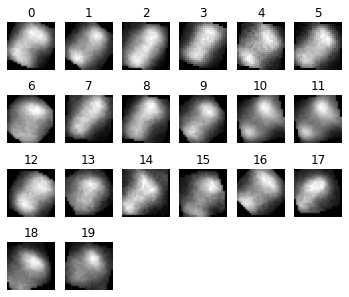

In [81]:
for i in range(int(mask.sum())):
    p = patches[mask][i]
    plt.subplot(4,6,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(transform_patch(p, *params[i]), cmap='gray')

plt.subplots_adjust(top=1.1)

Données ISIM

In [47]:
patches = get_patches(
    "/data/plumail/real_data/outputs/ISIM/tilt/pos80/pred_picked_particles/predictions.pickle",
    "/data/plumail/real_data/outputs/ISIM/picking/pos80/cropped/positive"
)

In [48]:
patches.shape

(32, 32, 32)

5 8


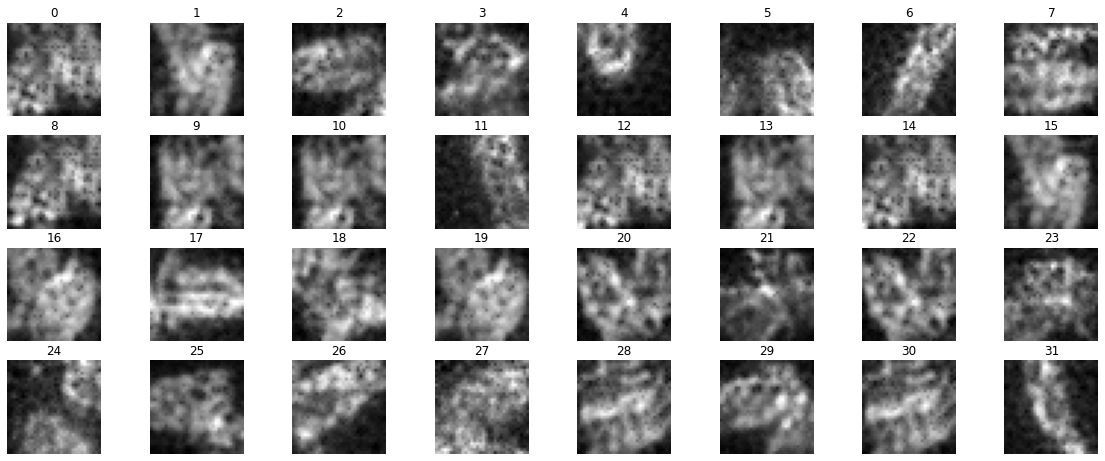

In [49]:
N = patches.shape[0]

plt.figure(figsize=(20,10))
h = int((N/1.5)**0.5) + 1
w = int(h * 1.5) + 1
print(h, w)

for i in range(patches.shape[0]):
    p = patches[i]
    plt.subplot(h,w,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(patches[i], cmap='gray')

In [53]:
mask_keep, params, avrg_particle, variance_map = iterative_suppression(patches, 10)

iterations= 2
N= 32
N= 16


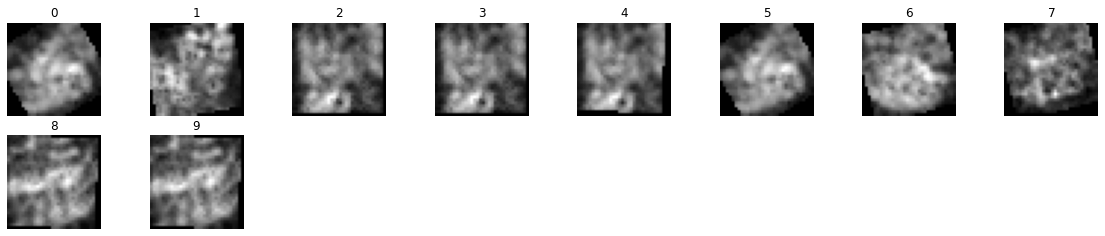

In [54]:
plt.figure(figsize=(20,10))

for i, p, param in zip(range(len(params)), patches[mask_keep], params):
    plt.subplot(h,w,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(transform_patch(p, *param), cmap='gray')

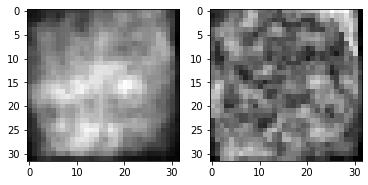

In [55]:
plt.subplot(1,2,1)
plt.imshow(avrg_particle, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(variance_map**0.5, cmap='gray')

Données ISIM annotées seulement

In [57]:
patches = get_patches(
    "/data/plumail/real_data/inputs/ISIM/views.csv",
    "/data/plumail/real_data/inputs/ISIM/annotated/cropped/positive"
)

6 10


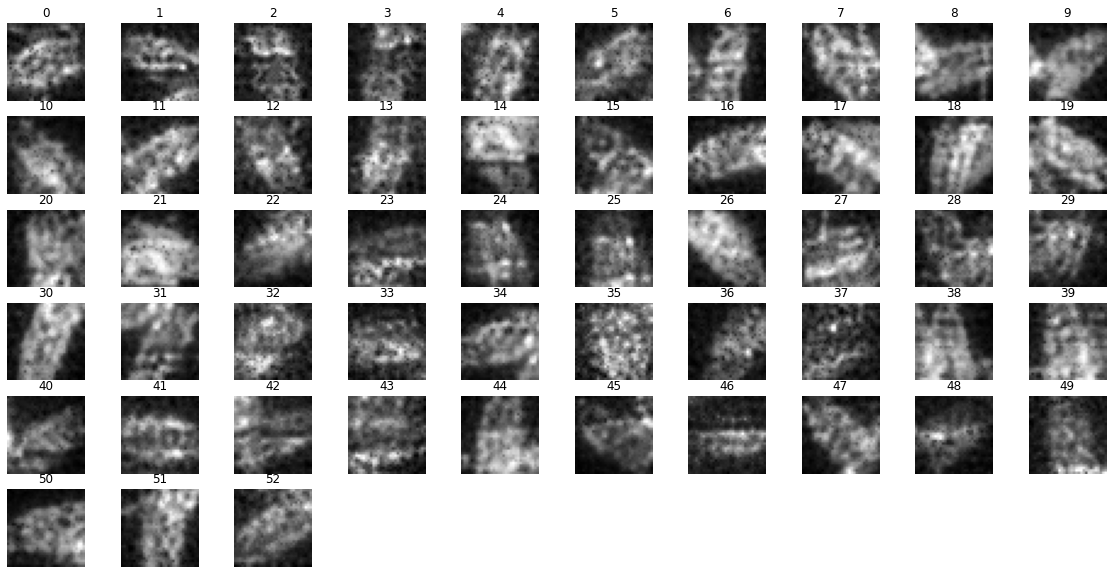

In [59]:
N = patches.shape[0]

plt.figure(figsize=(20,10))
h = int((N/1.5)**0.5) + 1
w = int(h * 1.5) + 1
print(h, w)

for i in range(patches.shape[0]):
    p = patches[i]
    plt.subplot(h,w,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(patches[i], cmap='gray')

In [62]:
mask_keep, params, avrg_particle, variance_map = iterative_suppression(patches, 20)

iterations= 2
N= 53
N= 27


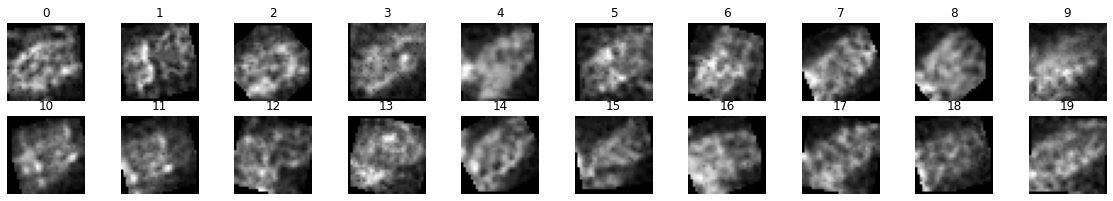

In [63]:
plt.figure(figsize=(20,10))

for i, p, param in zip(range(len(params)), patches[mask_keep], params):
    plt.subplot(h,w,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(transform_patch(p, *param), cmap='gray')

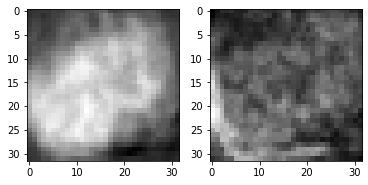

In [64]:
plt.subplot(1,2,1)
plt.imshow(avrg_particle, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(variance_map**0.5, cmap='gray')

Données générées

In [43]:
patches = get_patches(
    "/data/plumail/generated_data/exp_luc/outputs_tilting_luc/predictions.pickle",
    "/data/plumail/generated_data/exp_luc/inputs/test/cropped/positive"
)

8 13


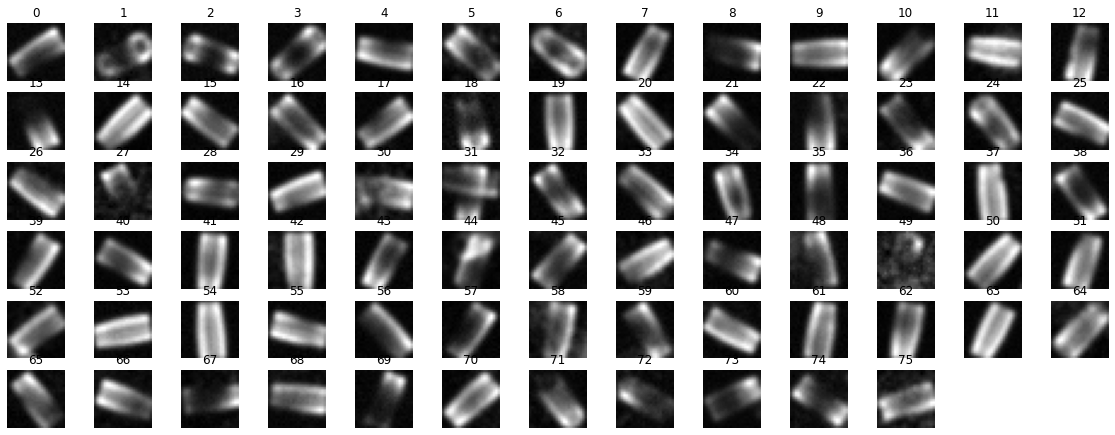

In [44]:
N = patches.shape[0]

plt.figure(figsize=(20,10))
h = int((N/1.5)**0.5) + 1
w = int(h * 1.5) + 1
print(h, w)

for i in range(patches.shape[0]):
    p = patches[i]
    plt.subplot(h,w,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(patches[i], cmap='gray')

In [45]:
mask_keep, params, avrg_particle, variance_map = iterative_suppression(patches, 15)

iterations= 3
N= 76
N= 38
N= 19


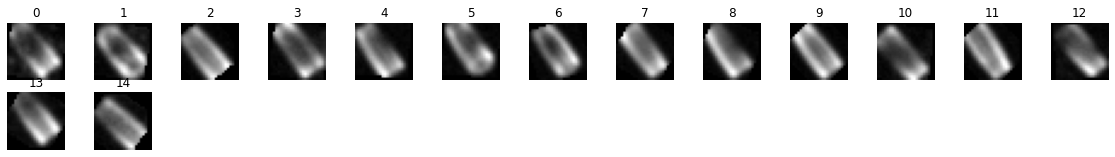

In [46]:
plt.figure(figsize=(20,10))

for i, p, param in zip(range(len(params)), patches[mask_keep], params):
    plt.subplot(h,w,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(transform_patch(p, *param), cmap='gray')

#### Améliorer la précision de la classification top/side/other

In [59]:
from modules.posttraining import predict_tilt

predictions = predict_tilt(
    "/data/plumail/generated_data/exp_luc/inputs/test/",
    "efficientnet-b0",
    "/data/plumail/generated_data/exp_luc/outputs_tilt/checkpoint_swa.pt",
    "/data/plumail/generated_data/exp_luc/inputs/test/cropped",
    2,
    512,
    "npz",
    2,
    None,
    "/data/plumail/generated_data/exp_luc/outputs_tilt/pred_picked_particles/"
)


+----------------------------------------------------------------------------------------------------------------+
|                                                   PREDICTION                                                   |
+----------------------------------------------------------------------------------------------------------------+
| rootdir........: /data/plumail/generated_data/exp_luc/inputs/test/                                             |
| network........: efficientnet-b0                                                                               |
| checkpoint_path: /data/plumail/generated_data/exp_luc/outputs_tilt/checkpoint_swa.pt                           |
| crop_dir.......: /data/plumail/generated_data/exp_luc/inputs/test/cropped                                      |
| dim............: 2                                                                                             |
| batch_size.....: 512                                                         

0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [61]:
logits = np.concatenate([predictions[image_name][1] for image_name in predictions], axis=0)
logits.shape

(300, 3)

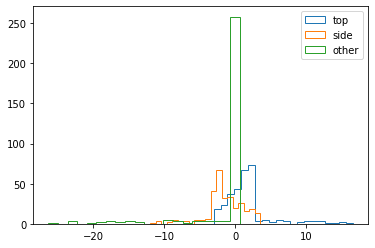

In [62]:
plt.hist(logits[:,0], label="top", histtype='step', bins=20)
plt.hist(logits[:,1], label="side", histtype='step', bins=20)
plt.hist(logits[:,2], label="other", histtype='step', bins=20)
plt.legend()

(array([1., 3., 2., 3., 3., 4., 5., 4., 8., 8., 8., 5., 5., 9., 9., 4., 3.,
        1., 3., 5.]),
 array([-1.7589117 , -1.4677458 , -1.1765798 , -0.8854139 , -0.59424794,
        -0.30308196, -0.01191601,  0.27924994,  0.5704159 ,  0.86158186,
         1.1527479 ,  1.4439138 ,  1.7350798 ,  2.0262456 ,  2.3174117 ,
         2.6085775 ,  2.8997436 ,  3.1909094 ,  3.4820755 ,  3.7732413 ,
         4.0644073 ], dtype=float32),
 <BarContainer object of 20 artists>)

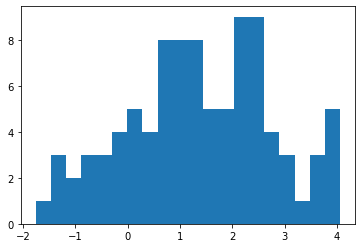

In [68]:
not_top = ~(logits.argmax(axis=1) == 0)
plt.hist(logits[not_top][:,1]-logits[not_top][:,2], bins=20, density=False)

In [69]:
views_pred = logits.argmax(axis=1)
views_pred[views_pred==1 & ((logits[:,1]-logits[:,2]) < 2)] = 2 # set unsure side to other

In [71]:
n1 = len(predictions["8.npz"][0])
n2 = len(predictions["9.npz"][0])
new_views_pred = [views_pred[:n1], views_pred[n1:n1+n2]]

for image_name, vpred in zip(predictions, new_views_pred):
    predictions[image_name] = (vpred, predictions[image_name][1], predictions[image_name][2])

with open(os.path.join("/data/plumail/generated_data/exp_luc/outputs_tilt/pred_picked_particles/", 'predictions.pickle'), 'wb') as file:
    pickle.dump(predictions, file)

In [72]:
patches = get_patches(
    "/data/plumail/generated_data/exp_luc/outputs_tilt/pred_picked_particles/predictions.pickle",
    "/data/plumail/generated_data/exp_luc/inputs/test/cropped/positive"
)

5 8


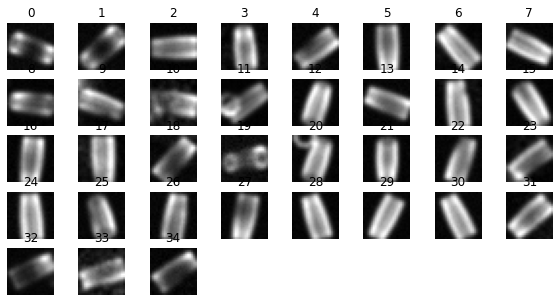

In [73]:
N = patches.shape[0]

plt.figure(figsize=(10,5))
h = int((N/1.5)**0.5) + 1
w = int(h * 1.5) + 1
print(h, w)

for i in range(patches.shape[0]):
    p = patches[i]
    plt.subplot(h,w,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(patches[i], cmap='gray')

In [77]:
mask_keep, params, avrg_particle, variance_map = iterative_suppression(patches, n=15)

iterations= 2
N= 35
N= 18


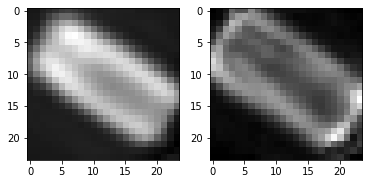

In [78]:
plt.subplot(1,2,1)
plt.imshow(avrg_particle, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(variance_map**0.5, cmap='gray')

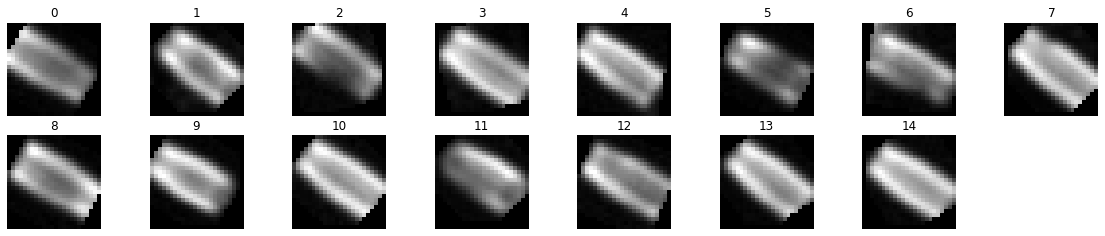

In [80]:
plt.figure(figsize=(20,10))

for i, p, param in zip(range(len(params)), patches[mask_keep], params):
    plt.subplot(h,w,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(transform_patch(p, *param), cmap='gray')

Même chose avec les données STED pickées

In [89]:
with open("/data/plumail/real_data/outputs/Nicollo_STED/tilt/pos40/pred_picked_particles/predictions.pickle", "rb") as f:
    predictions = pickle.load(f)

predictions.keys()

dict_keys(['Stack009_c1.tif', 'Stack017_c1.tif'])

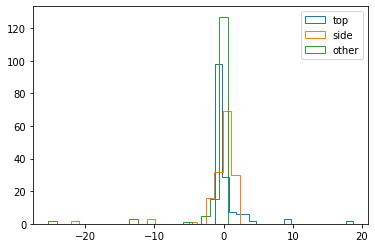

In [90]:
logits = np.concatenate([predictions[image_name][1] for image_name in predictions], axis=0)
plt.hist(logits[:,0], label="top", histtype='step', bins=20)
plt.hist(logits[:,1], label="side", histtype='step', bins=20)
plt.hist(logits[:,2], label="other", histtype='step', bins=20)
plt.legend()

(array([ 4.,  6., 10.,  8.,  7.,  8., 11., 13.,  6.,  9.,  7.,  5.,  7.,
         4.,  1.,  2.,  2.,  0.,  0.,  1.]),
 array([-1.1063472 , -0.87460256, -0.64285797, -0.41111332, -0.17936869,
         0.05237594,  0.28412056,  0.5158652 ,  0.74760985,  0.97935444,
         1.2110991 ,  1.4428437 ,  1.6745883 ,  1.906333  ,  2.1380775 ,
         2.3698223 ,  2.6015668 ,  2.8333116 ,  3.065056  ,  3.2968009 ,
         3.5285454 ], dtype=float32),
 <BarContainer object of 20 artists>)

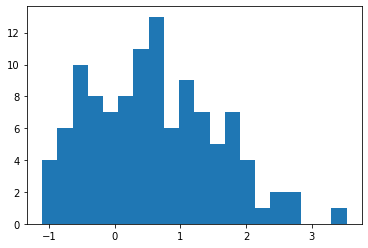

In [91]:
not_top = ~(logits.argmax(axis=1) == 0)
plt.hist(logits[not_top][:,1]-logits[not_top][:,2], bins=20, density=False)

In [92]:
views_pred = logits.argmax(axis=1)
views_pred[views_pred==1 & ((logits[:,1]-logits[:,2]) < 1)] = 2 # set unsure side to other

In [93]:
predictions.keys()

dict_keys(['Stack009_c1.tif', 'Stack017_c1.tif'])

In [94]:
n1 = len(predictions["Stack009_c1.tif"][0])
n2 = len(predictions["Stack017_c1.tif"][0])
new_views_pred = [views_pred[:n1], views_pred[n1:n1+n2]]

for image_name, vpred in zip(predictions, new_views_pred):
    predictions[image_name] = (vpred, predictions[image_name][1], predictions[image_name][2])

with open("/data/plumail/real_data/outputs/Nicollo_STED/tilt/pos40/pred_picked_particles/predictions-corrected.pickle", 'wb') as file:
    pickle.dump(predictions, file)

In [95]:
patches = get_patches(
    "/data/plumail/real_data/outputs/Nicollo_STED/tilt/pos40/pred_picked_particles/predictions-corrected.pickle",
    "/data/plumail/real_data/outputs/Nicollo_STED/picking/pos40/cropped/positive"
)

5 8


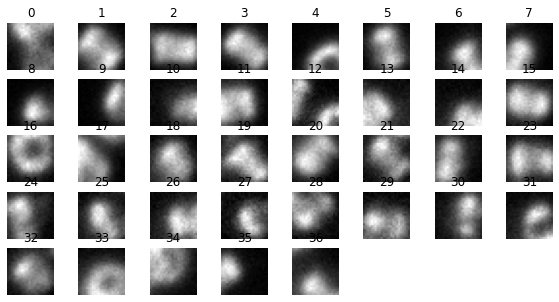

In [97]:
N = patches.shape[0]

plt.figure(figsize=(10,5))
h = int((N/1.5)**0.5) + 1
w = int(h * 1.5) + 1
print(h, w)

for i in range(patches.shape[0]):
    p = patches[i]
    plt.subplot(h,w,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(patches[i], cmap='gray')

C'est pas vraiment mieux en fait... Plus de FP en proportion qu'avant j'ai l'impression

In [104]:
mask_keep, params, avrg_particle, variance_map = iterative_suppression(patches, n=10)

iterations= 2
N= 37
N= 19


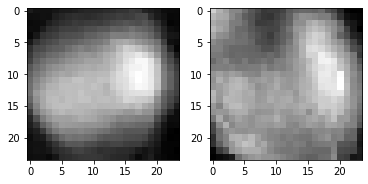

In [105]:
plt.subplot(1,2,1)
plt.imshow(avrg_particle, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(variance_map**0.5, cmap='gray')

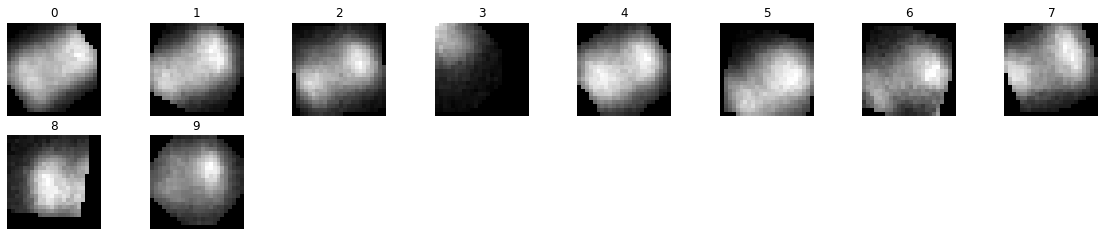

In [106]:
plt.figure(figsize=(20,10))

for i, p, param in zip(range(len(params)), patches[mask_keep], params):
    plt.subplot(h,w,i+1)
    plt.axis('off')
    plt.title(str(i))
    plt.imshow(transform_patch(p, *param), cmap='gray')

Moins bon que la méthode de suppression seule